In [69]:
import sys
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("C:/Users/r02as18/git/gempy/")
import gempy as gp

In [70]:
geo_data = gp.create_data([0,2000,0,2000,0,2000],
                          [100,100,100],
                          path_o = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_orientations.csv", # importing orientation (foliation) data
                          path_i = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_points.csv") # importing point-positional interface data

gp.set_series(geo_data, {"Fault_Series":'Main_Fault',
                         "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1')},
                          order_series = ["Fault_Series", 'Strat_Series'],
                          order_formations=['Main_Fault',
                                            'Sandstone_2','Siltstone', 'Shale', 'Sandstone_1'], verbose=0)

In [71]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  1


In [72]:
# create custom 2d grid
grid = []
for x in np.arange(0,2000,20):
    for y in [1000]:
        for z in np.arange(0,2000,20):
            grid.append([x,y,z])
grid = np.array(grid)

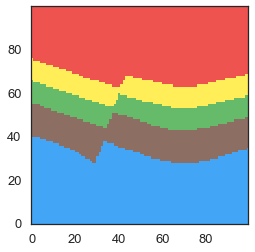

In [74]:
lb_init, fb_init = gp.compute_model_at(grid, interp_data)
plt.imshow(lb_init[0].reshape(100,100).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm);

In [75]:
geo_data.resolution = [100, 1, 100]
G_init, C_init, *topo = gp.topology_compute(geo_data, lb_init[0], fb_init)

In [76]:
from copy import deepcopy
geo_data_res_stoch = deepcopy(interp_data.geo_data_res)

## Priors

### Per-interface prior

In [24]:
priors = []
priors_names = []

for fmt in geo_data.formations.index:
    if "basement" in fmt:
        continue
    priors.append(ss.norm(0,200))
    priors_names.append(fmt)

### Per-point prior

## Sample priors

In [151]:
# sample
n_iter = 10000
prior_samples = []
for prior in priors:
    prior_samples.append(prior.rvs(n_iter))
    
prior_samples = np.array(prior_samples)
prior_samples.shape

(5, 10000)

## Initial DCT

In [89]:
from scipy import fftpack


def get_2D_dct(img):
    """Get 2D Cosine Transform of Image"""
    return fftpack.dct(fftpack.dct(img.T, norm='ortho', type=2).T, norm='ortho', type=2)


def get_2d_idct(coefficients):
    """Get 2D Inverse Cosine Transform of Image"""
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho', type=2).T, norm='ortho', type=2)


def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    return img

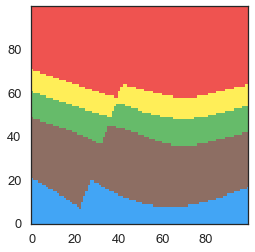

In [83]:
dct_init = get_2D_dct(lb_init[0].reshape(100,100))
model_reconstructed = get_reconstructed_image(get_2d_idct(dct_init))
plt.imshow(model_reconstructed.T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

Thickness of the brown layer appears to be not preserved correctly using the transform!

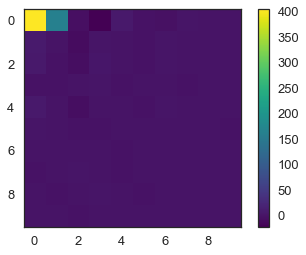

In [87]:
plt.imshow(dct_init[0:10,0:10], cmap="viridis")
plt.colorbar()

## Forward simulate models

In [153]:
import tqdm
import warnings
warnings.simplefilter("ignore")

lbs = []
fbs = []
graphs = []
centroids = []

for n in tqdm.tqdm(range(n_iter)):
    for i, fmt in enumerate(priors_names):
        f = interp_data.geo_data_res.interfaces["formation"] == fmt
        interp_data.geo_data_res.interfaces.set_value(f, "Z", geo_data_res_stoch.interfaces[f]["Z"] + (prior_samples[i, n] / interp_data.rescaling_factor))

    interp_data.update_interpolator()
    
    # print(np.sum(interp_data.geo_data_res.interfaces["Z"]))
    
    lb, fb = gp.compute_model_at(grid, interp_data)
    #G, C, *topo = gp.topology_compute(geo_data, lb[0], fb)
    
    #graphs.append(G)
    #centroids.append(C)
    lbs.append(lb)
    fbs.append(fb)
    
lbs = np.array(lbs)

 53%|████████████████████████████████████████████▏                                       | 5259/10000 [24:20<21:56,  3.60it/s]

KeyboardInterrupt: 

In [154]:
import ipywidgets

def f(i):
    plt.imshow(lbs[i][0].reshape(100,100).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm);
    plt.show()

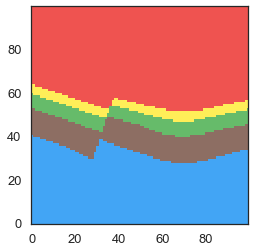

<function __main__.f(i)>

In [155]:
ipywidgets.interact(f, i=ipywidgets.IntSlider(min=0,max=n_iter-1,step=1,value=12))

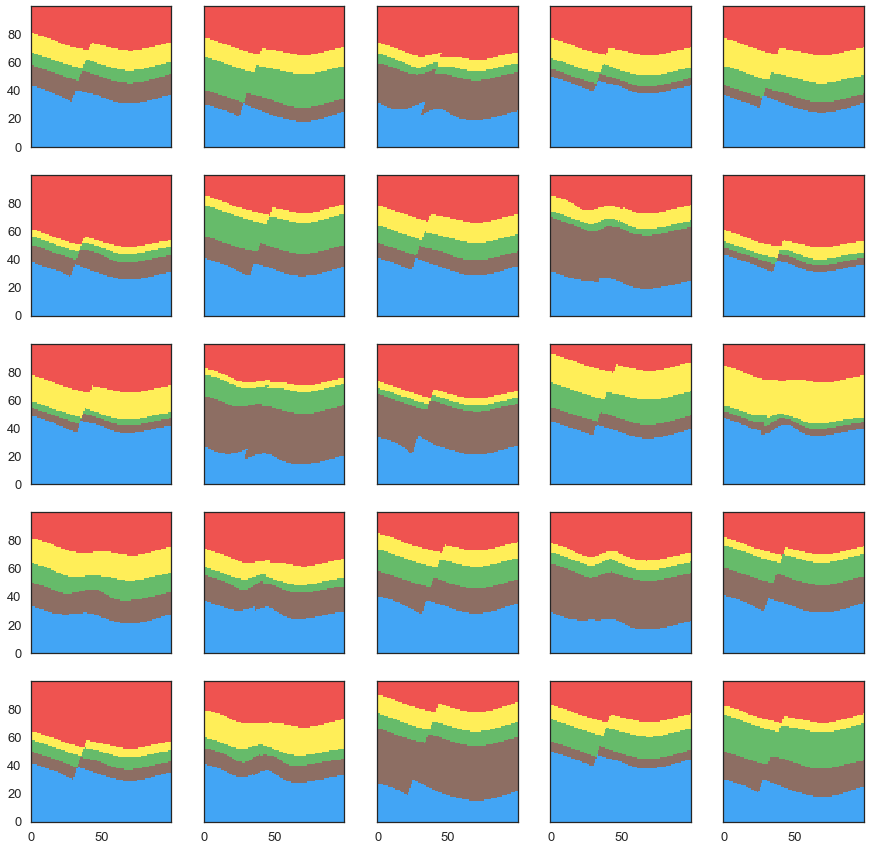

In [157]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15,15), sharex=True, sharey=True)

for ax in axes.flatten():
    ax.imshow(lbs[np.random.choice(len(lbs))][0].reshape(100,100).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

In [163]:
ie, iet = gp.posterior_analysis.calculate_ie(lbs[:,0,:].astype("int"))

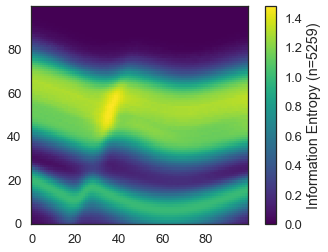

In [164]:
plt.imshow(ie.reshape(100,100).T, origin="lower", cmap="viridis")
plt.colorbar(label="Information Entropy (n="+str(lbs.shape[0])+")")

## Just take the dominant DCT coefficients:

## Rejection sampling of the simulated data:

In [170]:
epsilon = 0.85
posterior_lbs = []
posterior_fbs = []
posterior_ids = []

for i, lb in enumerate(lbs):
    # calculate dct of model realisation
    dct = get_2D_dct(lb[0].reshape(100,100))
    
    distance = np.average(np.sqrt(np.square(dct_init[0:2,0:4] - dct[0:2,0:4])))
    if distance < epsilon:
        posterior_lbs.append(lb)
        posterior_ids.append(i)
posterior_lbs = np.array(posterior_lbs)

In [171]:
posterior_lbs.shape

(27, 2, 10000)

In [172]:
ie_post, iet_post = gp.posterior_analysis.calculate_ie(posterior_lbs[:,0,:].astype("int"))

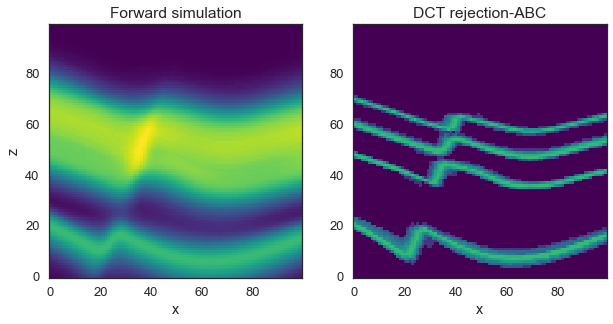

In [173]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

max_ = np.max([ie, ie_post])
min_ = np.min([ie, ie_post])

ax[0].imshow(ie.reshape(100,100).T, vmin=min_, vmax=max_, origin="lower", cmap="viridis")
im = ax[1].imshow(ie_post.reshape(100,100).T, vmin=min_, vmax=max_, origin="lower", cmap="viridis")

ax[0].set_title("Forward simulation")
ax[1].set_title("DCT rejection-ABC");
ax[0].set_ylabel("z")
ax[0].set_xlabel("x")
ax[1].set_xlabel("x");

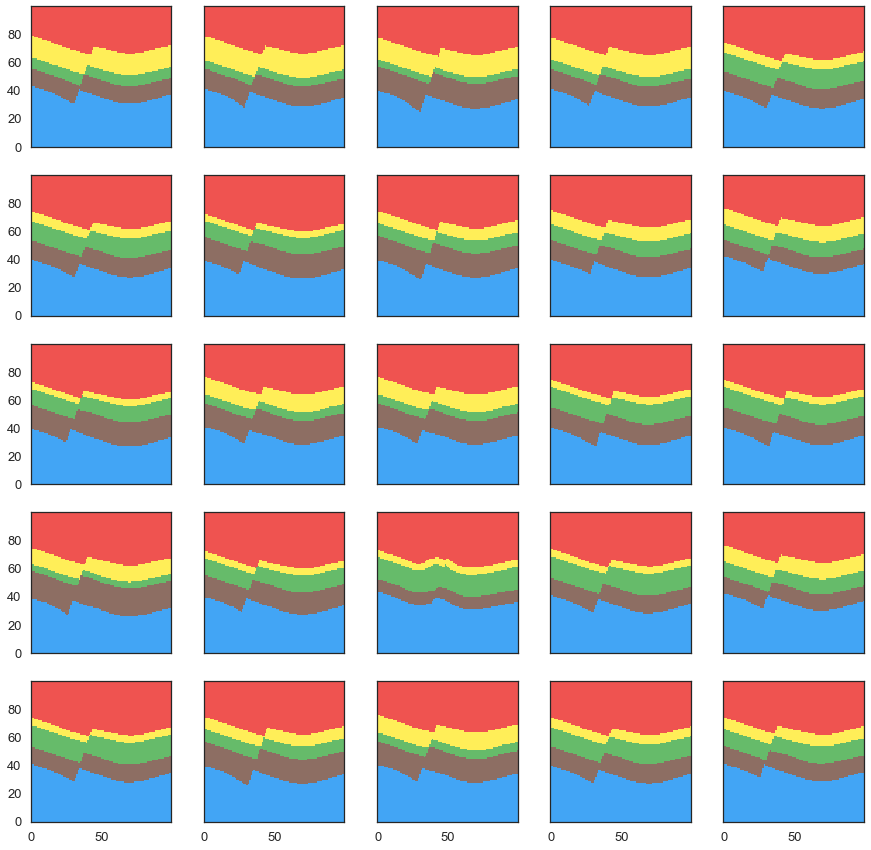

In [174]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15,15), sharex=True, sharey=True)

for ax in axes.flatten():
    ax.imshow(posterior_lbs[np.random.choice(posterior_lbs.shape[0])][0].reshape(100,100).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

In [36]:
jaccards = []
for graph in graphs:
    j = gp.topology.compare_graphs(G_init, graph)
    jaccards.append(j)
    
jaccards = np.array(jaccards)

In [38]:
np.mean(jaccards)

0.2144454327646594

In [39]:
np.mean(jaccards[posterior_ids])

0.21400936777194268

### todo

* prior / posterior parameter histograms

In [175]:
iet

0.6147175538542334

In [176]:
iet_post

0.13151614638647943